In [81]:
import datetime as dt
import pandas as pd
import math
from requests import get
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import holidays
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor



<font size="50">Preprocess</font>

<p>The goal of this part is to research web-scraped database and understand, what needs to be changed and how to preprocess it properly.
Let's take a look at our database's head:

In [82]:
movies = pd.read_csv("movies_data.csv")
model_data = movies.head(10).copy()
model_data.head()

,Title,ReleaseYr,ReleaseDate,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,Score,NumberOfScores,Budget,Gross
0,Houseguest,1995,January 6,"Rated PG for language, double entendre humor a...",1 hour 53 minutes,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,5.9,7K,$10500000,$26325256
1,The Matrix,1999,March 31,Rated R for sci-fi violence and brief language,2 hours 16 minutes,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,8.7,1.9M,$63000000,$467222728
2,The Next Best Thing,2000,March 3,"Rated PG-13 for mature thematic elements, sexu...",1 hour 48 minutes,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,4.6,11K,$25000000,$24362772
3,The Cable Guy,1996,June 14,Rated PG-13 for dark thematic elements and cru...,1 hour 36 minutes,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,6.1,163K,$47000000,$102825796
4,Higher Learning,1995,January 11,"Rated R for scenes of violence and sexuality, ...",2 hours 8 minutes,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,6.5,20K,NaN,$38290723


Bugs may happen, we need to be sure our database has no duplicates, even if there are actually none. So, just to
be sure, let's remove them, if there are any

In [83]:
model_data.drop_duplicates(inplace=True)

Of course movie's title can be catchy or can be not, but I don't think its impact on the gross is that big -
so our future model must not take that into the consideration. In other words, we can safely drop the title column. Also,
as we won't know our hypothetical movie's score, we will drop this column too.

In [84]:
def drop_title_and_score(data):
    return data.drop(columns=["Title", "Score"])


model_data = drop_title_and_score(model_data)
model_data.head()

,ReleaseYr,ReleaseDate,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross
0,1995,January 6,"Rated PG for language, double entendre humor a...",1 hour 53 minutes,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7K,$10500000,$26325256
1,1999,March 31,Rated R for sci-fi violence and brief language,2 hours 16 minutes,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1.9M,$63000000,$467222728
2,2000,March 3,"Rated PG-13 for mature thematic elements, sexu...",1 hour 48 minutes,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11K,$25000000,$24362772
3,1996,June 14,Rated PG-13 for dark thematic elements and cru...,1 hour 36 minutes,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163K,$47000000,$102825796
4,1995,January 11,"Rated R for scenes of violence and sexuality, ...",2 hours 8 minutes,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20K,NaN,$38290723


Let's take a closer look: what data types our database consists of?

In [85]:
types = model_data.dtypes
print(types)

ReleaseYr              object
ReleaseDate            object
AgeRating              object
Length                 object
Genres                 object
Directors              object
Writers                object
Stars                  object
Keywords               object
ProductionCompanies    object
NumberOfScores         object
Budget                 object
Gross                  object
dtype: object


Let's make columns, that obviously should be numerical, actually numerical

In [86]:



def remake_scores_number(scores_number: str):
    if isinstance(scores_number, str):
        number = "".join([i for i in scores_number if i.isnumeric() or i == "."])
        multiplier = scores_number.replace(number, "")
        if multiplier == "M":
            return float(number) * 1000000
        elif multiplier == "K":
            return float(number) * 1000
        else:
            return float(number)
    return None


def money_to_number(money: str):
    if isinstance(money, str):
        number = "".join([i for i in money if i.isnumeric()])
        if number:
            return int(number)
    return None


def length_to_number(length: str):
    if isinstance(length, str):
        if "hour" and "minute" in length:
            number = int(length.split("hour")[0]) * 60 + int(
                "".join([i for i in length.split(" hour")[1] if i.isnumeric()]))
        elif "hour" in length:
            number = int(length.split("hour")[0]) * 60
        else:
            number = int("".join([i for i in length if i.isnumeric()]))
        return number
    return None


def make_numerical(data):
    new_data = data.copy()
    new_data["Length"] = new_data["Length"].apply(length_to_number)
    new_data["ReleaseYr"] = new_data["ReleaseYr"].apply(pd.to_numeric, errors='coerce')
    new_data["NumberOfScores"] = new_data["NumberOfScores"].apply(remake_scores_number)
    new_data["Gross"] = new_data["Gross"].apply(money_to_number)
    new_data["Budget"] = new_data["Budget"].apply(money_to_number)
    return new_data


model_data = make_numerical(model_data)
types = model_data.dtypes
print(types)
model_data.head()

ReleaseYr                int64
ReleaseDate             object
AgeRating               object
Length                   int64
Genres                  object
Directors               object
Writers                 object
Stars                   object
Keywords                object
ProductionCompanies     object
NumberOfScores         float64
Budget                 float64
Gross                    int64
dtype: object


,ReleaseYr,ReleaseDate,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross
0,1995,January 6,"Rated PG for language, double entendre humor a...",113,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7000.0,10500000.0,26325256
1,1999,March 31,Rated R for sci-fi violence and brief language,136,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1900000.0,63000000.0,467222728
2,2000,March 3,"Rated PG-13 for mature thematic elements, sexu...",108,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11000.0,25000000.0,24362772
3,1996,June 14,Rated PG-13 for dark thematic elements and cru...,96,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163000.0,47000000.0,102825796
4,1995,January 11,"Rated R for scenes of violence and sexuality, ...",128,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20000.0,NaN,38290723


Inflation is pretty important to consider!

In [87]:
def consider_inflation(data):
    new_data = data.copy()
    start_year = min(data["ReleaseYr"])
    last_year = max(data["ReleaseYr"])
    years = []
    while start_year < last_year:
        years.append(start_year)
        start_year += 1
    for i in years:
        url = """https://www.officialdata.org/us/inflation/{}?endYear={}&amount=1&future_pct=0.03""".format(i,
                                                                                                            last_year)
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        inflation_rate_container = html_soup.find("div", class_="main-info")
        inflation_rate = float(inflation_rate_container.find_all("span", class_="highlighted-amount")[1].text[1:])
        new_data.loc[new_data['ReleaseYr'] == i, "Gross"] = new_data.loc[
                                                                new_data['ReleaseYr'] == i, "Gross"] * inflation_rate
        new_data.loc[new_data['ReleaseYr'] == i, "Budget"] = new_data.loc[
                                                                 new_data['ReleaseYr'] == i, "Budget"] * inflation_rate
    return new_data


model_data = consider_inflation(model_data)
model_data.head()

,ReleaseYr,ReleaseDate,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross
0,1995,January 6,"Rated PG for language, double entendre humor a...",113,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7000.0,13860000.0,3.474934e+07
1,1999,March 31,Rated R for sci-fi violence and brief language,136,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1900000.0,76230000.0,5.653395e+08
2,2000,March 3,"Rated PG-13 for mature thematic elements, sexu...",108,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11000.0,29250000.0,2.850444e+07
3,1996,June 14,Rated PG-13 for dark thematic elements and cru...,96,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163000.0,60160000.0,1.316170e+08
4,1995,January 11,"Rated R for scenes of violence and sexuality, ...",128,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20000.0,NaN,5.054375e+07


The next important step it's to get rid of dates, but of course not to simply drop them. The specific date is not
important by itself, but by the special period, it's representing. People around the world go to
the movie theatres more, when they are free from work, so it's pretty common for companies to release movies,
in which they're sure to make a lot of money, during the holidays. We'll orient mostly to the US holidays and
Chinese holidays, as they're the most common cultures, that a lot of other countries share
and usually are the most valuable countries for the gross.

In [88]:
def is_holiday(date: str):
    if isinstance(date, str):
        try:
            separated_date = date.split(" ")
            month, day = separated_date[0], separated_date[1]
            date = dt.date(year=2020, month=int(str(dt.datetime.strptime(month, "%B").month)), day=int(day))
            it_is = 0
            for holiday in [i[0] for i in holidays.UnitedStates(years=2020).items()]:
                if holiday - dt.timedelta(days=2) <= date <= holiday + dt.timedelta(days=5):
                    it_is = 1
            for holiday in [i[0] for i in holidays.China(years=2020).items()]:
                if holiday - dt.timedelta(days=2) <= date <= holiday + dt.timedelta(days=5):
                    it_is = 1
            return it_is
        except IndexError:  #sometimes there is no full date, just a month
            pass
    return 0


def release_date_to_holiday(data):
    new_data = data.copy()
    new_data["ReleaseDate"] = new_data["ReleaseDate"].apply(is_holiday)
    new_data = new_data.rename(columns={"ReleaseDate": "ReleasedDuringHolidays"})
    return new_data


model_data = release_date_to_holiday(model_data)
model_data.head()

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross
0,1995,1,"Rated PG for language, double entendre humor a...",113,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7000.0,13860000.0,3.474934e+07
1,1999,0,Rated R for sci-fi violence and brief language,136,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1900000.0,76230000.0,5.653395e+08
2,2000,0,"Rated PG-13 for mature thematic elements, sexu...",108,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11000.0,29250000.0,2.850444e+07
3,1996,0,Rated PG-13 for dark thematic elements and cru...,96,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163000.0,60160000.0,1.316170e+08
4,1995,0,"Rated R for scenes of violence and sexuality, ...",128,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20000.0,NaN,5.054375e+07


Age ratings are unnecessarily accurate - we don't need this much information. Let's remake them to the simple rating


In [89]:



def remake_ratings(rating: str):
    ratings = ['TV-PG', 'PG-13', 'PG', 'R', 'Not Rated', 'NC-17', 'Unrated', 'TV-14', 'TV-MA', 'G']
    if isinstance(rating, str):
        for i in ratings:
            if i in rating:
                return i
    return None


def simplify_ratings(rating: str):
    adult = ['R', 'NC-17', 'TV-MA']
    teen = ['PG-13', 'TV-14']
    kids = ['G', 'TV-PG', 'PG']
    if isinstance(rating, str):
        if rating in adult:
            return "R"  #basically, adult only rating
        elif rating in teen:
            return "PG-13"  #basically, teen and adults rating
        elif rating in kids:
            return "PG"  #basically, all ages rating
    return None


def remake_age_rating(data):
    new_data = data.copy()
    new_data["AgeRating"] = new_data["AgeRating"].apply(remake_ratings)
    new_data["AgeRating"] = new_data["AgeRating"].apply(simplify_ratings)
    return new_data


model_data = remake_age_rating(model_data)
model_data.head()

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross
0,1995,1,PG,113,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7000.0,13860000.0,3.474934e+07
1,1999,0,R,136,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1900000.0,76230000.0,5.653395e+08
2,2000,0,PG-13,108,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11000.0,29250000.0,2.850444e+07
3,1996,0,PG-13,96,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163000.0,60160000.0,1.316170e+08
4,1995,0,R,128,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20000.0,NaN,5.054375e+07


Now let's take a closer look at the columns with multiple values separated with a plus sign. Gross has a strong
dependency on society's interest in the movie. The overall interest in a
moviemaker is highly correlated with the number of people, who watch the movies with him, which highly correlates with
the number of people, who rated the movie on IMDb. So I think the good way to deal with these features is to simply rate
them. Of course, we are more interested in the modern situation, so there are the rules:
<p>the score of genres column would be the <b>average</b> score between all genres,
  which would be the average number of views of the last <b>100</b> movies of this genre, or all movies, if there are fewer;
  There will also be a new column "IsAnimated".
  If it's an animated movie, this genre will be excluded, and the value in ("IsAnimated" column, movie's row)-cell will be 1.
<p>score of directors/writers would be the <b>maximum</b> between the scores of all directors/writers,
  which would be the average number of views of the last <b>5</b> movies of this person, or all movies, if there are fewer;
<p>score of stars would be the <b>sum</b> between the scores of all stars,
  which would be the average number of views of the last <b>5</b> movies of this person, or all movies, if there are fewer;
<p>score of product companies would be the <b>maximum</b> between the scores of all product companies,
  which would be the average number of views of the last <b>50</b> movies of this studio, or all movies, if there are fewer;
<p>finally, a score of keywords would be the <b>average</b> between the scores of top-10 keywords (by appearances in movies),
  which would be the average number of views of the last <b>50</b> movies that include this keyword, or all movies, if there are fewer;
<p>It's important to note, that some specific keywords will be excluded, because, in my opinion, they are significantly more important.
They will make their columns, with 1 in the cell if a movie had a keyword related to the topic, and 0 if not.
Those specific topics are: if the film includes superheroes? if the film is a part of a franchise? if the film's story is original?


In [90]:
def calc_appearances(column_name, data):
    appearances = {}
    for string in data[column_name]:
        if isinstance(string, str):
            i_list = string.split("+")
        else:
            i_list = [None]
        for word in i_list:
            if word not in appearances.keys():
                appearances[word] = 1
            else:
                appearances[word] += 1
    sorted_dict = dict(sorted(appearances.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict


def make_new_columns(column_name: str, remake_dict: dict, data):
    new_data = data.copy()
    column = new_data[column_name]
    for key in remake_dict.keys():
        is_in_list = []
        for item in column:
            is_in = False
            value_list = remake_dict[key]
            if isinstance(item, str):
                for phrase in item.split("+"):
                    for string in value_list:
                        if string in phrase:
                            is_in = True
                            new_item = "+".join([i for i in item.split("+") if phrase not in i])
                            new_data.loc[new_data[column_name] == item, column_name] = new_item
            if is_in:
                is_in_list.append(1)
            else:
                is_in_list.append(0)
        new_data[key] = is_in_list
    return new_data


def add_columns(data):
    new_data = data.copy()
    new_data = make_new_columns("Genres", {"IsAnimated": ["Animation"]}, new_data)
    new_data = make_new_columns("Keywords", {"IsSuperheroMovie": ["superhero", "comic"],
                                             "IsPartOfFranchise": ["sequel", "prequel"],
                                             "IsNotOriginal": ["based on", "adapted"]}, new_data)
    return new_data


model_data = add_columns(model_data)
model_data.head()

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Genres,Directors,Writers,Stars,Keywords,ProductionCompanies,NumberOfScores,Budget,Gross,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal
0,1995,1,PG,113,Comedy,Randall Miller,Michael J. Di Gaetano+Lawrence Gay,Sinbad+Phil Hartman+Kim Greist,cartoon on tv+liar revealed+reference to pearl...,Hollywood Pictures+Caravan Pictures,7000.0,13860000.0,3.474934e+07,0,0,0,0
1,1999,0,R,136,Action+Sci-Fi,Lana Wachowski+Lilly Wachowski,Lilly Wachowski+Lana Wachowski,Keanu Reeves+Laurence Fishburne+Carrie-Anne Moss,artificial reality+war with machines+simulated...,Warner Bros.+Village Roadshow Pictures+Groucho...,1900000.0,76230000.0,5.653395e+08,0,0,0,0
2,2000,0,PG-13,108,Comedy+Drama+Romance,John Schlesinger,Tom Ropelewski,Madonna+Rupert Everett+Benjamin Bratt,breakup+watching tv+gay friend+custody battle+...,Lakeshore Entertainment+Paramount Pictures,11000.0,29250000.0,2.850444e+07,0,0,0,0
3,1996,0,PG-13,96,Comedy+Drama+Thriller,Ben Stiller,Lou Holtz Jr.,Jim Carrey+Matthew Broderick+Leslie Mann,television+obsession+revenge+friendship+hostag...,Columbia Pictures+Brillstein-Grey Entertainmen...,163000.0,60160000.0,1.316170e+08,0,0,0,0
4,1995,0,R,128,Crime+Drama+Thriller,John Singleton,John Singleton,Omar Epps+Kristy Swanson+Michael Rapaport,racism+lesbian+anger+sex scene+destroying a ro...,Columbia Pictures+New Deal Productions,20000.0,NaN,5.054375e+07,0,0,0,0


In [91]:
# here and further ignore_last_n is the number, of last n rows, that will not be considered during different
# metrics calculation, but it's important to note, that they will be remade due to those metrics to.
# it's needed to calculate scores without data of dream movies, that doesn't exist, and whose grosses we will calculate later

def remake_categorical(data, column_name: str, strategy: str, last_n_movies: int, top_10=False, ignore_last_n=0):
    new_data = data.copy()
    column = new_data[column_name]
    all_appearances = calc_appearances(column_name, new_data)
    all_appearances2 = copy.deepcopy(all_appearances)
    output = []
    for index in column.index:
        all_scores_list = []
        if isinstance(column[index], str):
            if top_10:
                appearances = {}
                for word in column[index].split("+"):
                    appearances[word] = all_appearances[word]
                appearances = dict(sorted(appearances.items(), key=lambda item: item[1]))
                if len(appearances) < 10:
                    words = "+".join([l for l in appearances.keys()])
                else:
                    words = "+".join([l for l in appearances.keys()][0:10])
            else:
                words = column[index]
            for word in words.split("+"):
                scores_list = []
                if ignore_last_n > 0:
                    without_ignored = new_data.head(-ignore_last_n).sort_values(by=["ReleaseYr"])
                else:
                    without_ignored = new_data.sort_values(by=["ReleaseYr"])
                if all_appearances[word] - all_appearances2[word] + 1 < last_n_movies - ignore_last_n:
                    last_n_movies_of_this_word = without_ignored[
                        without_ignored[column_name].str.contains(word, na=False)]
                    last_n_movies_of_this_word = last_n_movies_of_this_word.head(
                        all_appearances[word] - all_appearances2[word] + 1)
                    all_appearances2[word] += -1
                else:
                    last_n_movies_of_this_word = without_ignored[
                        without_ignored[column_name].str.contains(word, na=False)].sort_values("ReleaseYr",
                                                                                               ascending=False).head(
                        last_n_movies)
                for number in last_n_movies_of_this_word["NumberOfScores"]:
                    scores_list.append(number)
                try:
                    score = sum(scores_list) / len(scores_list)
                    all_scores_list.append(score)
                except ZeroDivisionError:
                    all_scores_list.append(0)
            if strategy == "average":
                output.append(sum(all_scores_list) / len(all_scores_list))
            elif strategy == "sum":
                output.append(sum(all_scores_list))
            elif strategy == "max":
                output.append(max(all_scores_list))
            else:
                print("Wrong strategy!")
        else:
            output.append(None)
    new_data[column_name + "_points"] = output
    new_data.drop(column_name, axis=1, inplace=True)
    return new_data


def remake_all_categorical(data, ignore_last_n=0):
    new_data = data.copy()
    new_data = remake_categorical(new_data, "Genres", "average", 100, ignore_last_n=ignore_last_n)
    new_data = remake_categorical(new_data, "Writers", "max", 5, ignore_last_n=ignore_last_n)
    new_data = remake_categorical(new_data, "Directors", "max", 5, ignore_last_n=ignore_last_n)
    new_data = remake_categorical(new_data, "Stars", "sum", 5, ignore_last_n=ignore_last_n)
    new_data = remake_categorical(new_data, "ProductionCompanies", "max", 50, ignore_last_n=ignore_last_n)
    new_data = remake_categorical(new_data, "Keywords", "average", 50, top_10=True, ignore_last_n=ignore_last_n)
    #we won't know movie's number of votes, so we don't need this column now
    return new_data.drop("NumberOfScores", axis=1)


model_data = remake_all_categorical(model_data)
model_data.head()

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Budget,Gross,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Genres_points,Writers_points,Directors_points,Stars_points,ProductionCompanies_points,Keywords_points
0,1995,1,PG,113,13860000.0,3.474934e+07,0,0,0,0,7.000000e+03,7000.0,7000.0,21000.0,7000.0,7000.0
1,1999,0,R,136,76230000.0,5.653395e+08,0,0,0,0,1.005000e+06,1900000.0,1900000.0,5700000.0,1900000.0,1900000.0
2,2000,0,PG-13,108,29250000.0,2.850444e+07,0,0,0,0,1.343333e+05,11000.0,11000.0,33000.0,11000.0,20900.0
3,1996,0,PG-13,96,60160000.0,1.316170e+08,0,0,0,0,7.977778e+04,163000.0,163000.0,489000.0,163000.0,163000.0
4,1995,0,R,128,NaN,5.054375e+07,0,0,0,0,9.061111e+04,20000.0,20000.0,60000.0,91500.0,20000.0


Now the only non-numerical feature is AgeRating. Let's make it numerical too!

In [92]:
def enumerate_rating(data):
    new_data = data.copy()
    scale_mapper = {"PG": 1, "PG-13": 2, "R": 3}
    new_data["AgeRating"].replace(scale_mapper, inplace=True)
    return new_data


model_data = enumerate_rating(model_data)
model_data.head(10)

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Budget,Gross,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Genres_points,Writers_points,Directors_points,Stars_points,ProductionCompanies_points,Keywords_points
0,1995,1,1,113,13860000.0,3.474934e+07,0,0,0,0,7.000000e+03,7000.0,7000.0,21000.0,7000.0,7000.0
1,1999,0,3,136,76230000.0,5.653395e+08,0,0,0,0,1.005000e+06,1900000.0,1900000.0,5700000.0,1900000.0,1900000.0
2,2000,0,2,108,29250000.0,2.850444e+07,0,0,0,0,1.343333e+05,11000.0,11000.0,33000.0,11000.0,20900.0
3,1996,0,2,96,60160000.0,1.316170e+08,0,0,0,0,7.977778e+04,163000.0,163000.0,489000.0,163000.0,163000.0
4,1995,0,3,128,NaN,5.054375e+07,0,0,0,0,9.061111e+04,20000.0,20000.0,60000.0,91500.0,20000.0
5,2006,1,3,73,1600000.0,2.619660e+05,0,0,0,0,1.073333e+05,8100.0,8100.0,24300.0,8100.0,18290.0
6,2005,0,3,120,NaN,7.259546e+06,0,0,0,1,6.843556e+04,7700.0,7700.0,23100.0,7700.0,7700.0
7,1996,0,3,115,128000000.0,3.101383e+08,0,0,0,0,3.754028e+05,110000.0,110000.0,330000.0,1005000.0,110000.0
8,1995,1,3,101,3300000.0,7.903350e+06,0,0,0,0,1.195667e+05,298000.0,298000.0,894000.0,298000.0,298000.0
9,2005,1,1,85,30900000.0,1.999612e+08,1,0,0,0,2.614667e+05,134000.0,134000.0,402000.0,134000.0,121700.0


It's time for us to deal with missing values. So missing values in following columns will be replaced to:
<p>Release year -> mode
<p>Released during holidays -> 0
<p>Age rating -> mode
<p>Length -> median
<p>Budget -> 1st quartile (as movies without info about budget in imdb tend to look cheap)
<p>Gross -> is a goal, so we'll drop the rows without it
<p>Is animated -> 0
<p>Is superhero movie -> 0
<p>Is part of franchise -> 0
<p>Is not original -> 0
<p>Genres points -> mean
<p>Writers points -> 1st quartile
<p>Directors points -> 1st quartile
<p>Stars points -> 1st quartile
<p>Production companies -> 1st quartile
<p>Keywords points -> mean

In [93]:
def deal_with_na(data, ignore_last_n=0):
    new_data = data.copy()
    new_data['ReleaseYr'].fillna(new_data['ReleaseYr'].mode()[0], inplace=True)
    new_data['ReleasedDuringHolidays'].fillna(0, inplace=True)
    new_data['AgeRating'].fillna(new_data['AgeRating'].mode()[0], inplace=True)
    new_data['Length'].fillna(new_data['Length'].median(), inplace=True)
    new_data['Budget'].fillna(new_data['Budget'].describe()['25%'], inplace=True)
    if ignore_last_n > 0:
        remake_data = new_data.head(-ignore_last_n).dropna(subset=["Gross"])
        new_data = remake_data.append(new_data.tail(ignore_last_n))
    else:
        new_data.dropna(subset=["Gross"], inplace=True)
    new_data['IsAnimated'].fillna(0, inplace=True)
    new_data['IsSuperheroMovie'].fillna(0, inplace=True)
    new_data['IsPartOfFranchise'].fillna(0, inplace=True)
    new_data['IsNotOriginal'].fillna(0, inplace=True)
    new_data['Genres_points'].fillna(new_data['Genres_points'].mean(), inplace=True)
    new_data['Writers_points'].fillna(new_data['Writers_points'].describe()['25%'], inplace=True)
    new_data['Directors_points'].fillna(new_data['Directors_points'].describe()['25%'], inplace=True)
    new_data['Stars_points'].fillna(new_data['Stars_points'].describe()['25%'], inplace=True)
    new_data['ProductionCompanies_points'].fillna(new_data['ProductionCompanies_points'].describe()['25%'],
                                                  inplace=True)
    new_data['Keywords_points'].fillna(new_data['Keywords_points'].mean(), inplace=True)
    return new_data


model_data = deal_with_na(model_data)
model_data.head()

,ReleaseYr,ReleasedDuringHolidays,AgeRating,Length,Budget,Gross,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Genres_points,Writers_points,Directors_points,Stars_points,ProductionCompanies_points,Keywords_points
0,1995,1,1,113,13860000.0,3.474934e+07,0,0,0,0,7.000000e+03,7000.0,7000.0,21000.0,7000.0,7000.0
1,1999,0,3,136,76230000.0,5.653395e+08,0,0,0,0,1.005000e+06,1900000.0,1900000.0,5700000.0,1900000.0,1900000.0
2,2000,0,2,108,29250000.0,2.850444e+07,0,0,0,0,1.343333e+05,11000.0,11000.0,33000.0,11000.0,20900.0
3,1996,0,2,96,60160000.0,1.316170e+08,0,0,0,0,7.977778e+04,163000.0,163000.0,489000.0,163000.0,163000.0
4,1995,0,3,128,11220000.0,5.054375e+07,0,0,0,0,9.061111e+04,20000.0,20000.0,60000.0,91500.0,20000.0


And a few final steps - then we are ready to go. Let's normalize values and remove skewness using a log

In [94]:
def log(column_name, data):
    new_data = data.copy()
    logged_column = []
    for index in new_data.index:
        logged_column.append(math.log(new_data[column_name][index] + 1))
    final_column = []
    for number in logged_column:
        final_column.append(number)
    new_data.drop(column_name, axis=1, inplace=True)
    new_data[column_name] = final_column
    return new_data


def normalize_data(data):
    new_data = data.copy()
    for column in ['Length', 'Budget', 'Genres_points', 'Writers_points', 'Directors_points', 'Stars_points',
                   'ProductionCompanies_points', 'Keywords_points']:
        new_data = log(column, new_data)
    new_data_to_normalize = new_data.drop(
        ["Gross", "AgeRating", "ReleaseYr", "ReleasedDuringHolidays", "IsAnimated", "IsSuperheroMovie",
         "IsPartOfFranchise", "IsNotOriginal"], axis=1)
    normalized_data = (new_data_to_normalize - new_data_to_normalize.min()) / (
            new_data_to_normalize.max() - new_data_to_normalize.min())
    new_data = normalized_data.join(new_data[
                                        ["AgeRating", "ReleaseYr", "ReleasedDuringHolidays", "IsAnimated",
                                         "IsSuperheroMovie", "IsPartOfFranchise", "IsNotOriginal", "Gross"]])
    return new_data


model_data = normalize_data(model_data)
model_data.head()

,Length,Budget,Genres_points,Writers_points,Directors_points,Stars_points,ProductionCompanies_points,Keywords_points,AgeRating,ReleaseYr,ReleasedDuringHolidays,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Gross
0,0.701611,0.492695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1995,1,0,0,0,0,3.474934e+07
1,1.000000,0.881727,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3,1999,0,0,0,0,0,5.653395e+08
2,0.628792,0.663135,0.594818,0.080651,0.080651,0.080656,0.080651,0.195187,2,2000,0,0,0,0,0,2.850444e+07
3,0.439420,0.827700,0.489905,0.561733,0.561733,0.561740,0.561733,0.561733,2,1996,0,0,0,0,0,1.316170e+08
4,0.902310,0.444473,0.515541,0.187333,0.187333,0.187341,0.458690,0.187333,3,1995,0,0,0,0,0,5.054375e+07


What a beautiful dataframe to see! Now let's make a function, that preprocesses the whole data we have.

In [95]:
def preprocess_data(data, ignore_last_n=0):
    new_data = data.copy()
    new_data.drop_duplicates(inplace=True)
    new_data.reset_index(drop=True, inplace=True)
    new_data = drop_title_and_score(new_data)
    new_data = make_numerical(new_data)
    new_data = consider_inflation(new_data)
    new_data = release_date_to_holiday(new_data)
    new_data = remake_age_rating(new_data)
    new_data = add_columns(new_data)
    new_data = remake_all_categorical(new_data, ignore_last_n)
    new_data = enumerate_rating(new_data)
    new_data = deal_with_na(new_data, ignore_last_n)
    new_data = normalize_data(new_data)
    return new_data


But before moving further...
<p>It would save a lot of time, if we will preprocess features of potential movies with the existing dataset.
So it's time for us to use our imagination, and create the dataframe of movies using create_film.py programm!
Go make a dream movie there (or a even a couple of them)! And if it's already done - let's preprocess the whole thing.
<p>And note that this part takes around 5 min - nothing compared to time of imdb_parse.py (~1.5 hours),
but still quite a while. Please wait a little :)

In [96]:
dream_movies = pd.read_csv("dream_movies.csv")
all_data = movies.append(dream_movies)
all_data.reset_index(drop=True, inplace=True)
preprocessed_data = preprocess_data(all_data, ignore_last_n=dream_movies.shape[0])
preprocessed_data.tail(10)

C:\Users\0CFA~1\AppData\Local\Temp/ipykernel_23008/1160187837.py:33: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  without_ignored[column_name].str.contains(word, na=False)]
C:\Users\0CFA~1\AppData\Local\Temp/ipykernel_23008/1160187837.py:39: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  without_ignored[column_name].str.contains(word, na=False)].sort_values("ReleaseYr",


,Length,Budget,Genres_points,Writers_points,Directors_points,Stars_points,ProductionCompanies_points,Keywords_points,AgeRating,ReleaseYr,ReleasedDuringHolidays,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Gross
5009,0.464915,0.777485,0.794714,0.668222,0.057230,0.455017,0.834923,0.725397,3.0,2018.0,0,0,0,0,0,2.472902e+07
5010,0.413063,0.764190,0.755399,0.080509,0.347833,0.501956,0.704786,0.772587,3.0,2017.0,0,0,0,0,0,3.608225e+06
5011,0.357256,0.817372,0.830461,0.543776,0.554224,0.710589,0.829765,0.696071,3.0,2018.0,0,0,0,0,1,9.297544e+07
5012,0.288928,0.764190,0.719270,0.060852,0.022286,0.231281,0.822121,0.594578,3.0,2017.0,0,0,0,0,0,3.005277e+05
5013,0.501527,0.833277,0.796560,0.657531,0.570437,0.706848,0.862426,0.707764,3.0,2018.0,1,0,0,1,0,9.024691e+07
5014,0.471145,0.699306,0.700183,0.027621,0.255464,0.152667,0.596456,0.363477,3.0,2017.0,0,0,0,0,0,2.168821e+06
5015,0.378685,0.764190,0.741750,0.254687,0.259581,0.621992,0.740444,0.509792,3.0,2017.0,1,0,0,0,0,4.006189e+04
5016,0.477324,0.942489,0.876805,0.703012,0.701841,0.751307,0.925971,0.803385,2.0,2018.0,1,0,1,1,1,7.409822e+08
5017,0.501527,0.843983,0.794714,0.750533,0.764954,0.790425,0.853908,0.820651,3.0,2017.0,0,0,0,1,0,2.075728e+08
5018,0.280927,0.895705,0.734137,0.881003,0.877568,0.779545,0.809097,0.736359,3.0,2023.0,1,1,1,1,1,NaN


<font size="50">Analyzing</font>
<p>Now it's time for some graphs to come in. We'll check correlations and how grosses are distributed

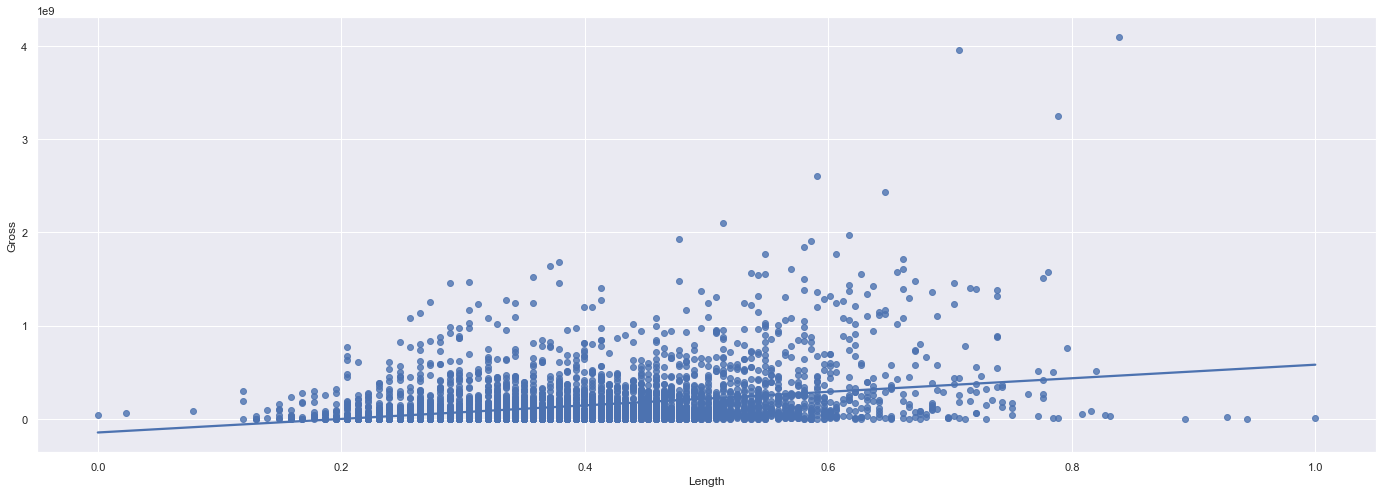

r = 0.3120809785556138




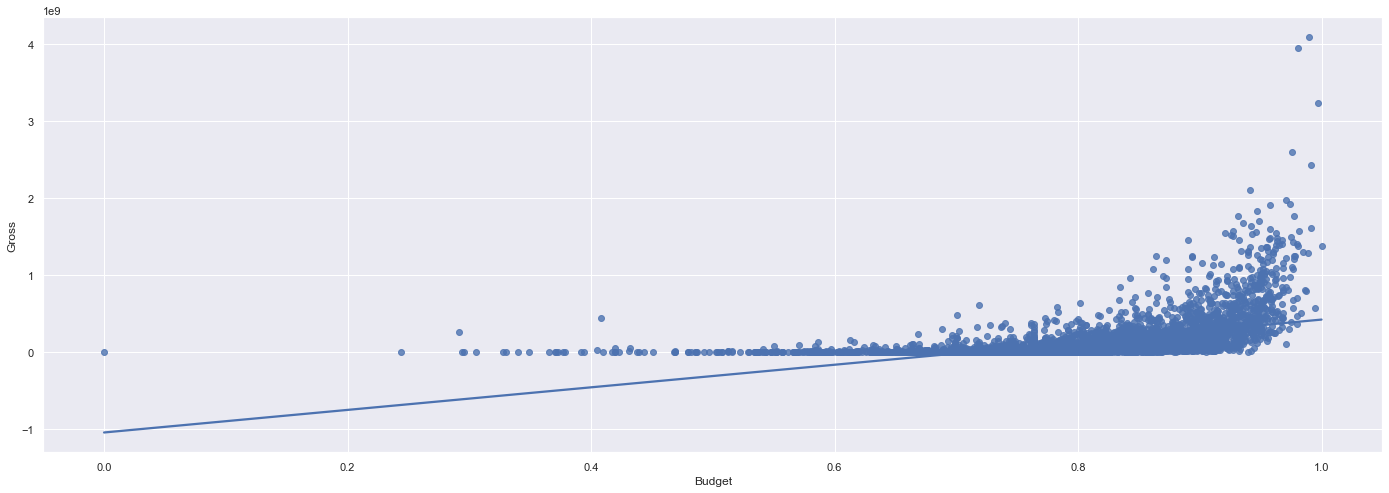

r = 0.5163218813280075




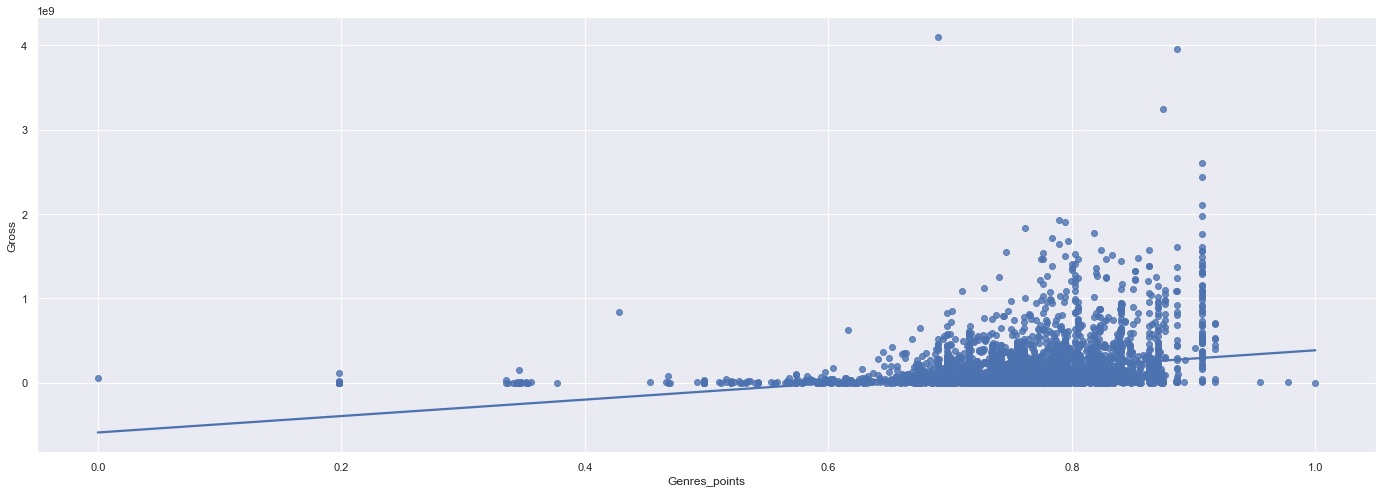

r = 0.29446473294617176




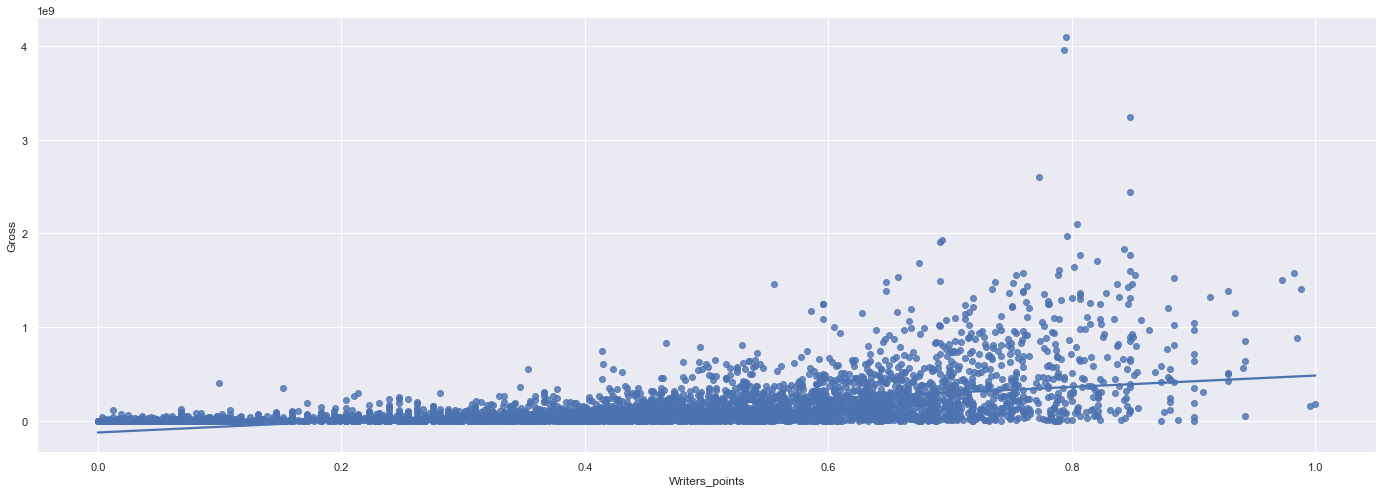

r = 0.5060992395779721




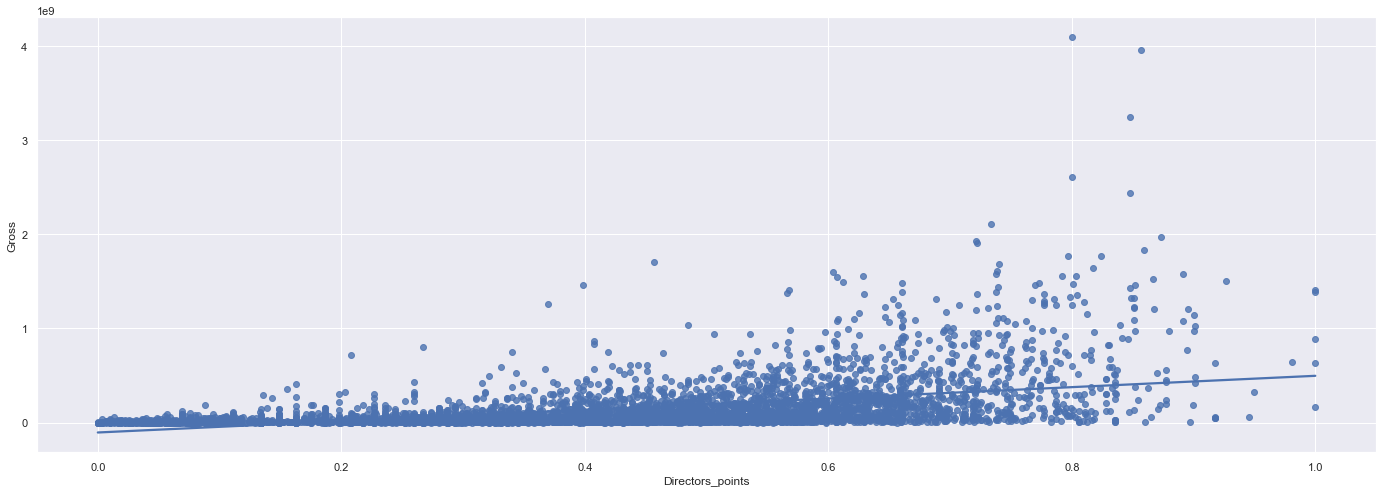

r = 0.495435804223938




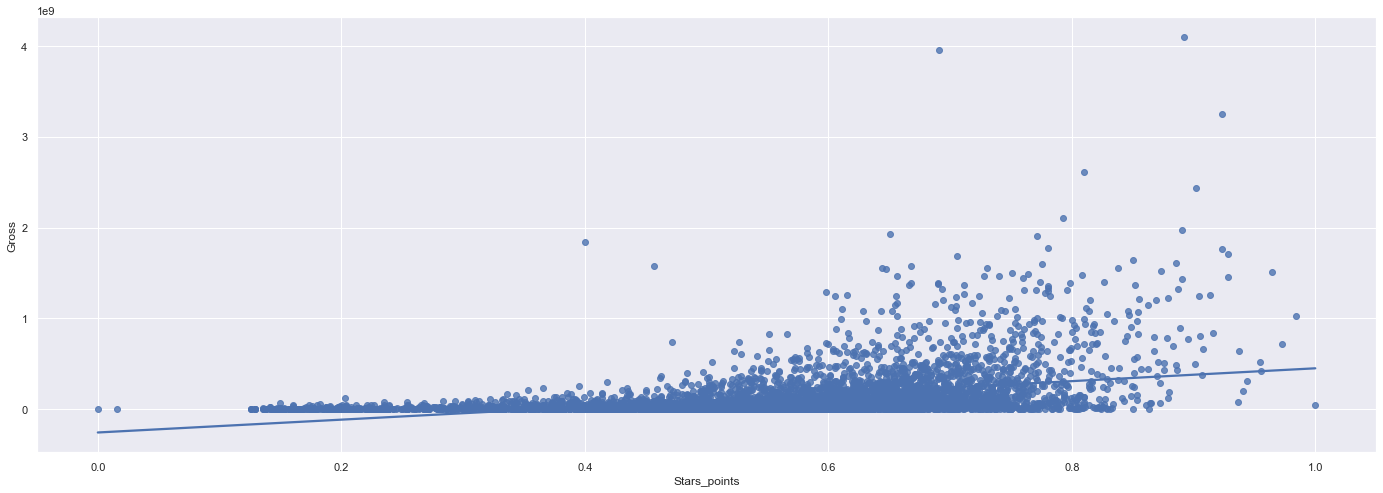

r = 0.41352962610469624




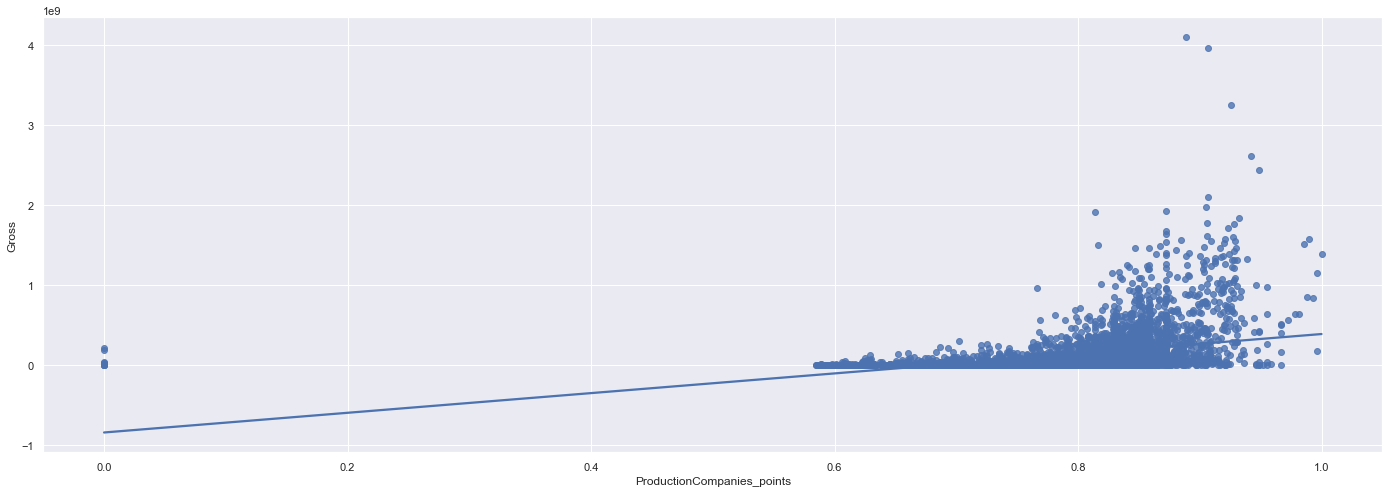

r = 0.3905579211430991




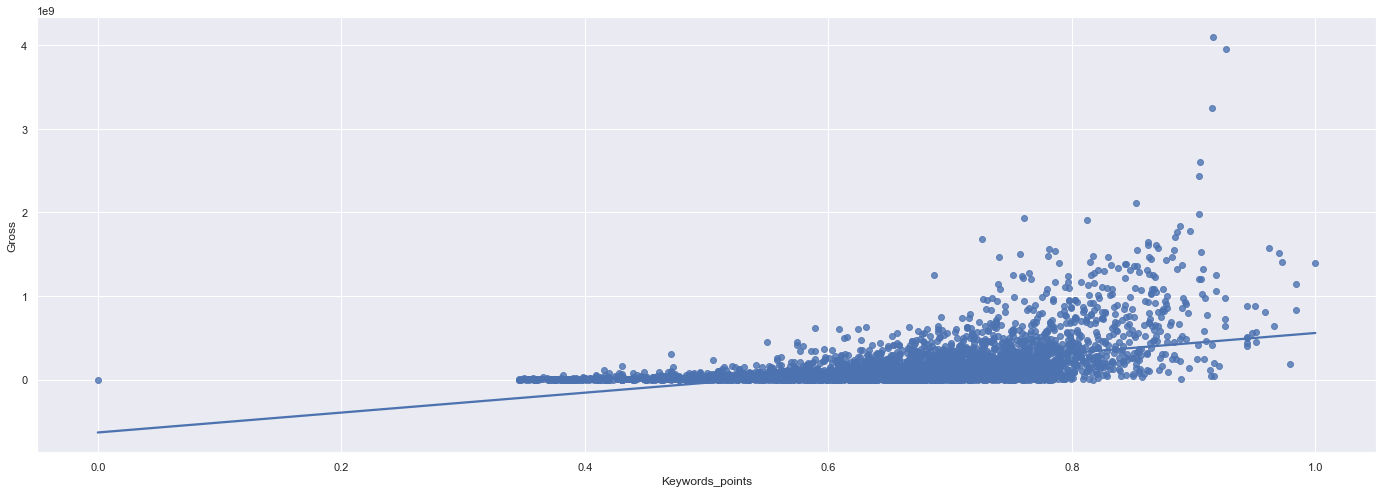

r = 0.5129754031833671




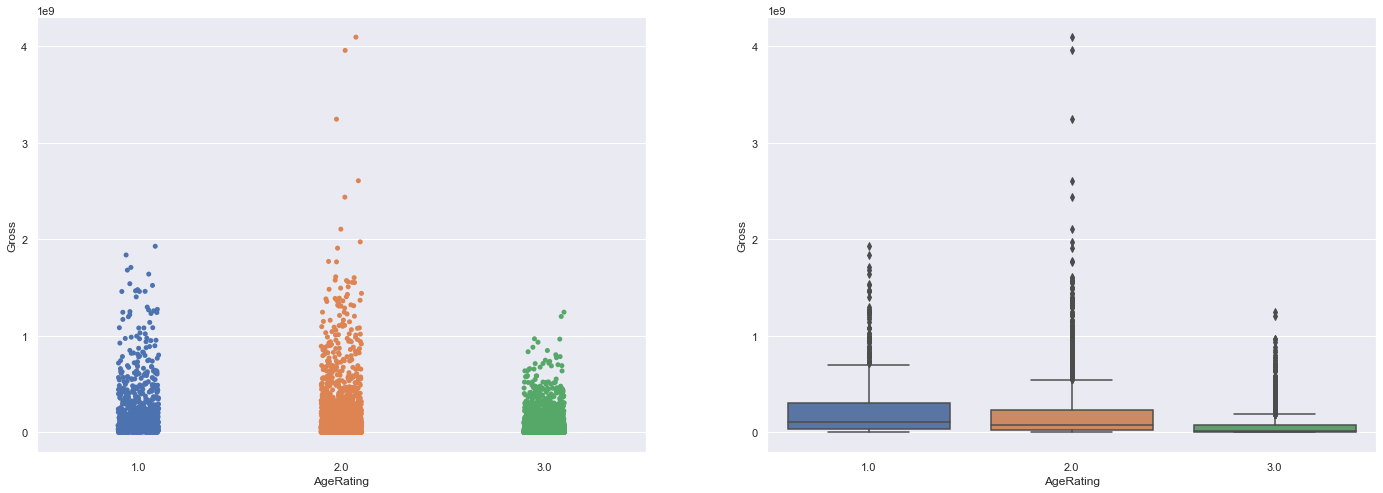

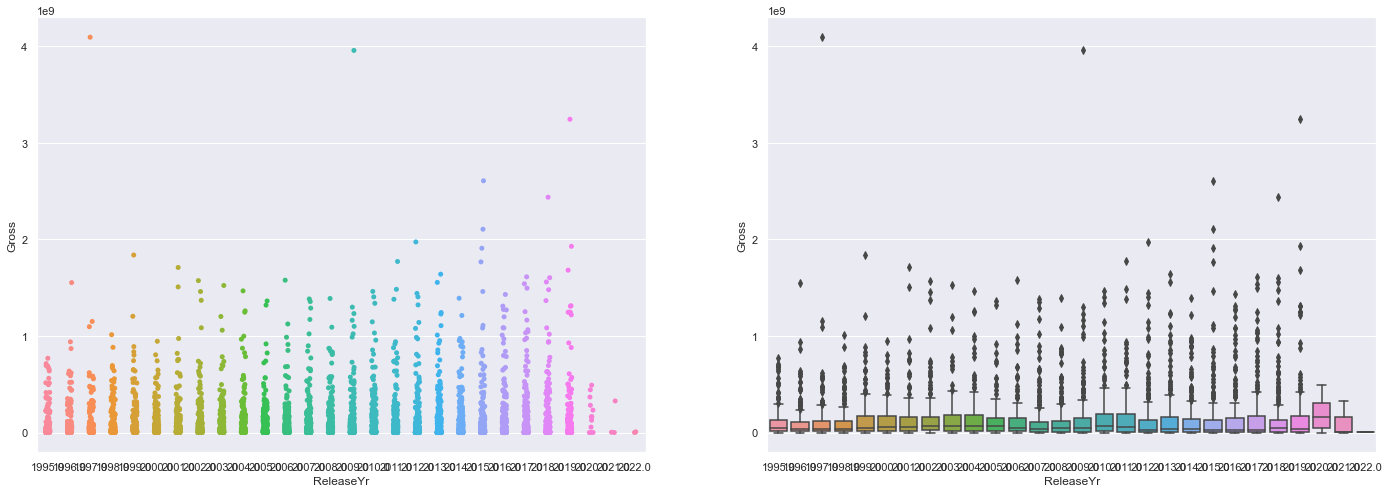

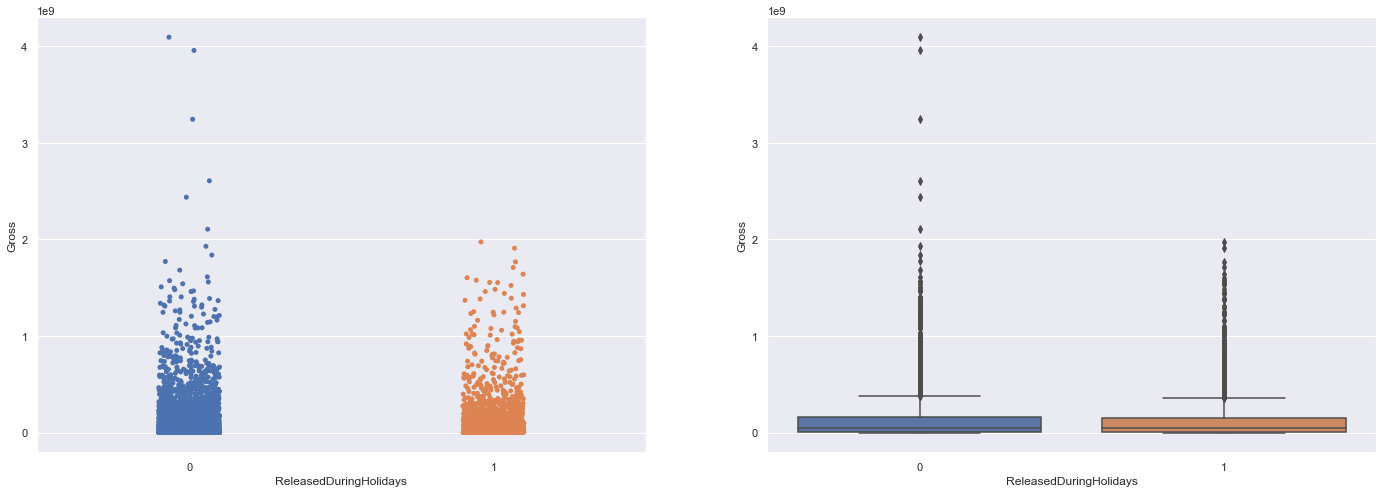

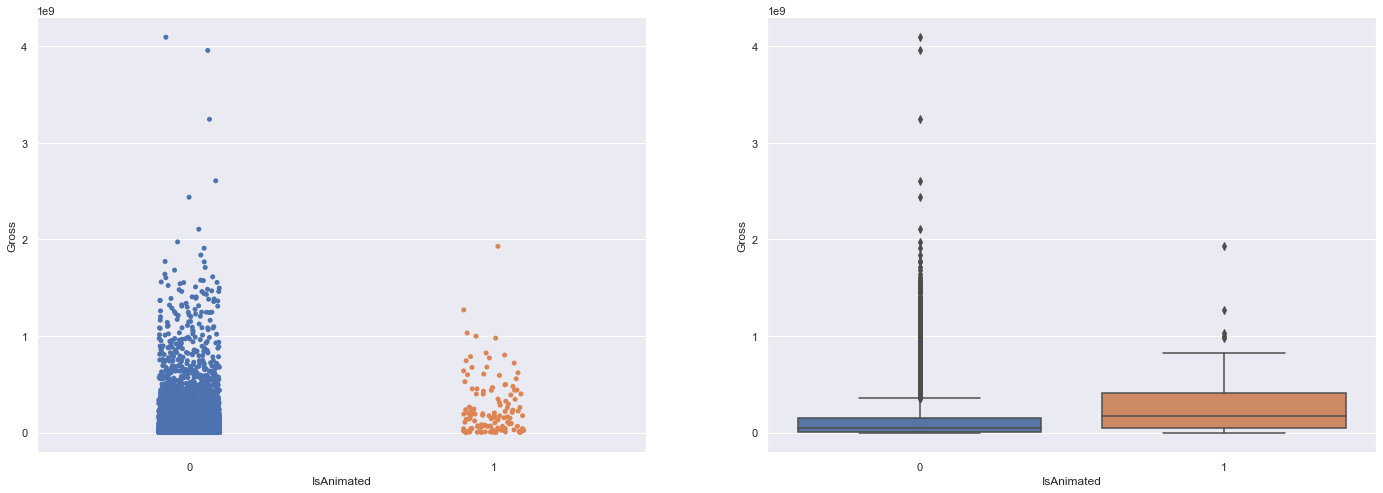

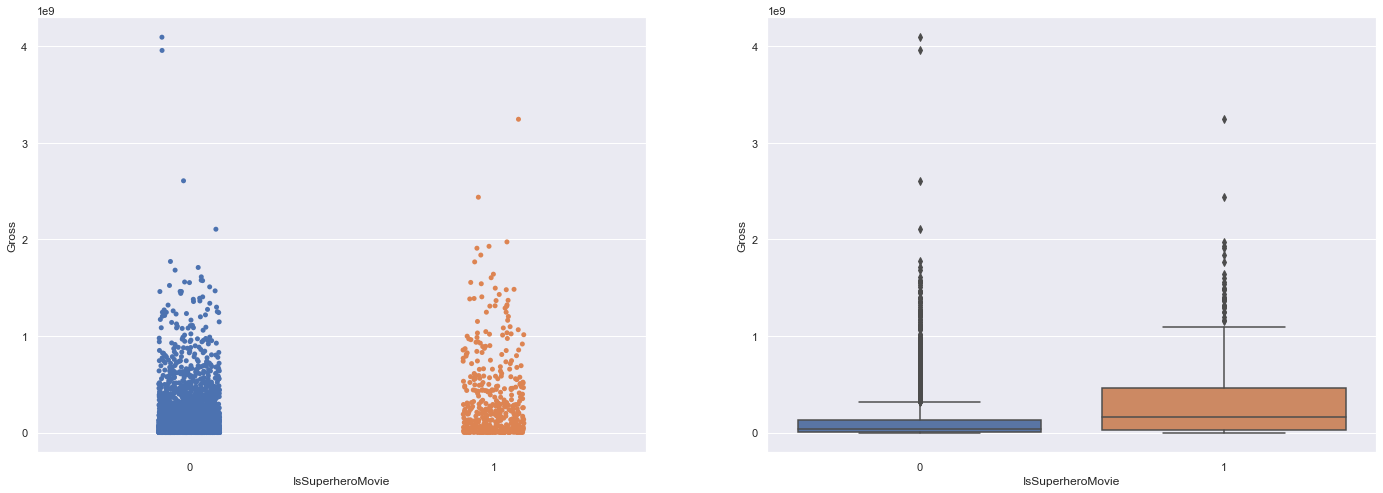

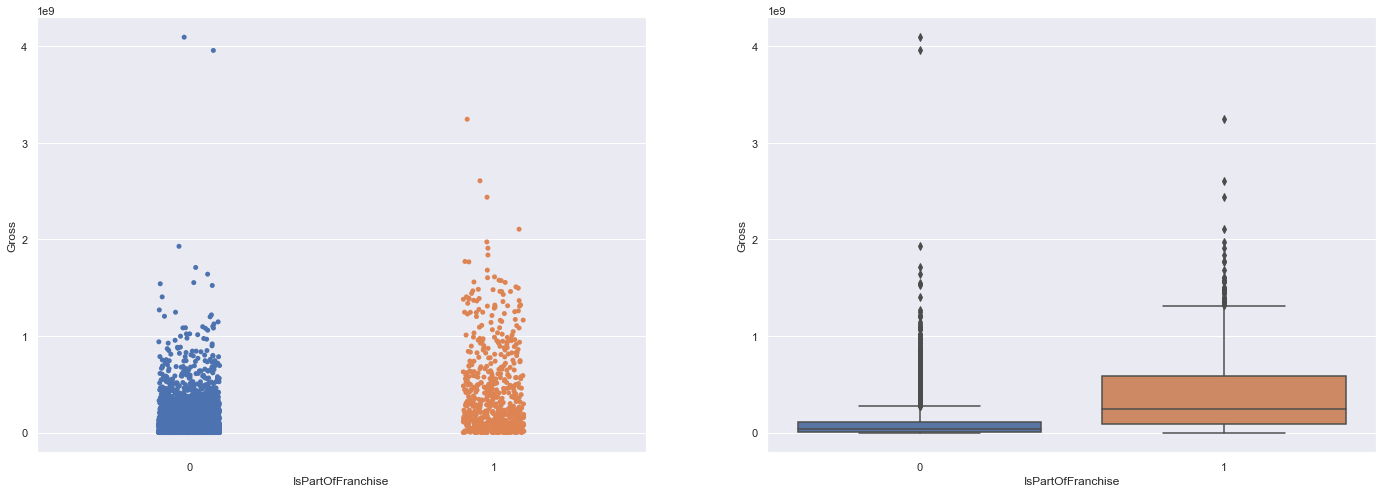

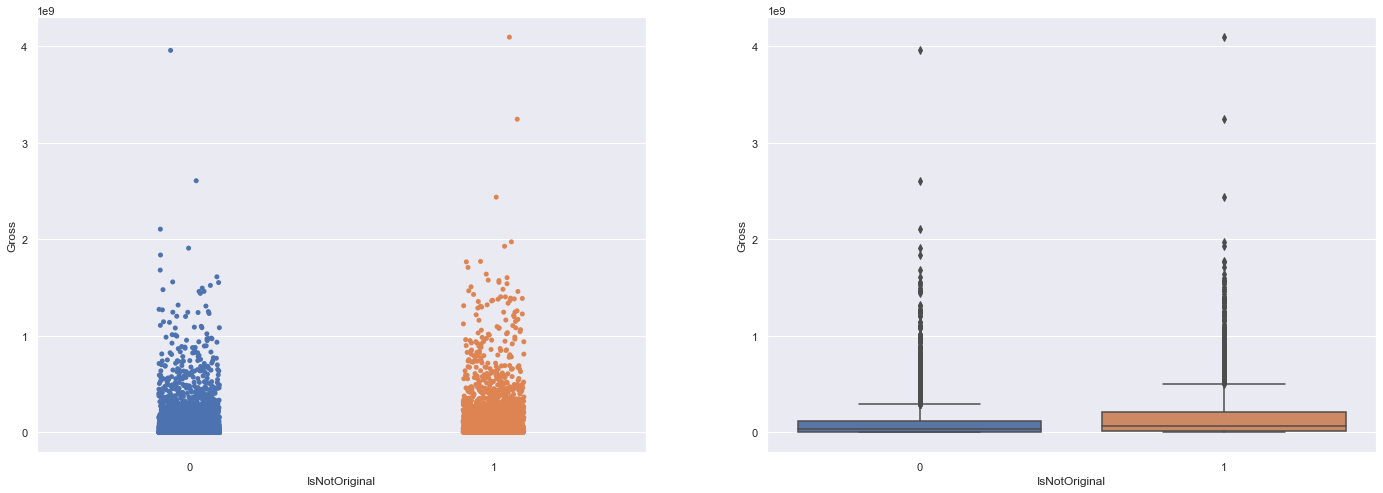

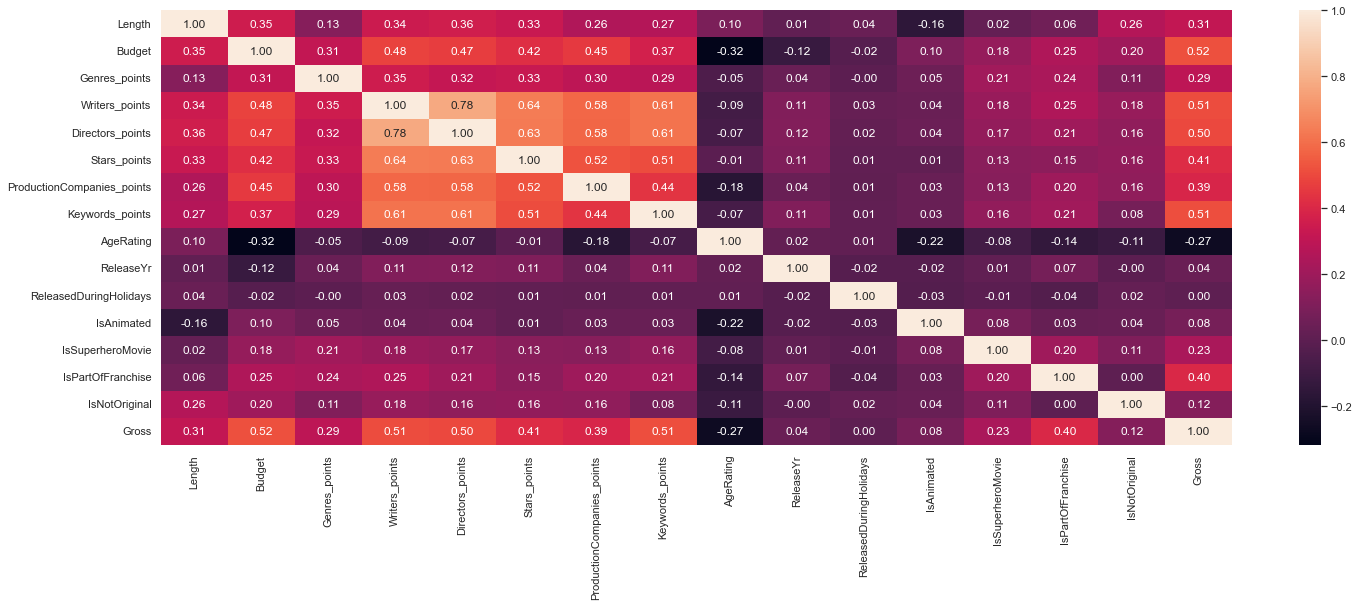

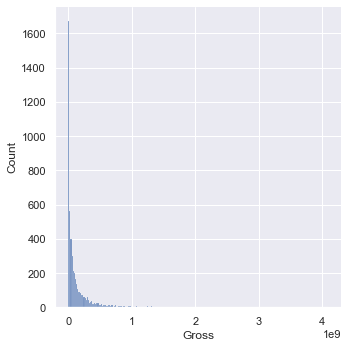

In [97]:
def plot_data(data: pd.DataFrame):
    x_axis = data.iloc[:, 0]
    y_axis = data.iloc[:, 1]
    sns.regplot(x=x_axis, y=y_axis, data=data, ci=None)
    plt.show()


def calc_r(df: pd.DataFrame):
    n = len(df.index)
    sum_xy = sum([df.iloc[:, 0][i] * df.iloc[:, 1][i] for i in df.index])
    sum_x = sum([i for i in df.iloc[:, 0]])
    sum_y = sum([i for i in df.iloc[:, 1]])
    sum_x2 = sum([i ** 2 for i in df.iloc[:, 0]])
    sum_y2 = sum([i ** 2 for i in df.iloc[:, 1]])
    r = (n * sum_xy - sum_x * sum_y) / (((n * sum_x2 - sum_x ** 2) * (n * sum_y2 - sum_y ** 2)) ** (1 / 2))
    print("r = " + str(r) + "\n\n")
    return r


dream_data = preprocessed_data.tail(dream_movies.shape[0])
dream_X = dream_data.drop("Gross", axis=1)

X = preprocessed_data.head(-dream_movies.shape[0]).drop("Gross", axis=1)
y = preprocessed_data.head(-dream_movies.shape[0])["Gross"]
sns.set(rc={'figure.figsize': (24, 8)})
correlations = {}
for i in ['Length', 'Budget', 'Genres_points', 'Writers_points', 'Directors_points', 'Stars_points',
          'ProductionCompanies_points', 'Keywords_points']:
    plot_data(pd.concat([X[i], y], axis=1))
    r = calc_r(pd.concat([X[i], y], axis=1))
    correlations[i] = r

for i in ['AgeRating', 'ReleaseYr', 'ReleasedDuringHolidays', 'IsAnimated', 'IsSuperheroMovie', 'IsPartOfFranchise',
          'IsNotOriginal']:
    fig, axs = plt.subplots(ncols=2)
    sns.stripplot(x=X[i],y=y, ax=axs[0])
    sns.boxplot(x=X[i], y=y, ax=axs[1])
    plt.show()


sns.heatmap(preprocessed_data.head(-dream_movies.shape[0]).corr(), annot=True, fmt=".2f")
sns.displot(x="Gross", data=preprocessed_data)
plt.show()

As we can see, ReleasedDuringHolidays, despite my assumptions, doesn't correlate with literally any other feature -
which is sad, and box graphs show us, that grosses of movies released during holidays, and those that are not, are identical.
So it has no place in our data - we will drop it.
<p>Also, that's not a big surprise that all -_points features
(except genres) highly correlated, and they all also strongly correlate with gross - that's simply means, that we need to join
them in the new feature.
<p>Gross distribution skewness is big - let's log that too

In [106]:
def sum_points(data):
    new_data = data.copy()
    cols = ["Writers_points", "Directors_points", "Stars_points", "ProductionCompanies_points", "Keywords_points"]
    scores = []
    for i in data.index:
        score = 0
        for j in cols:
            score += correlations[j] * data.loc[i, j]
        scores.append(score)
    new_data["Points"] = scores
    for j in cols:
        new_data.drop(j, axis=1, inplace=True)
    return new_data


preprocessed_data = sum_points(preprocessed_data)
preprocessed_data.drop("ReleasedDuringHolidays", axis=1, inplace=True)
dream_data = preprocessed_data.tail(dream_movies.shape[0])
X = preprocessed_data.head(-dream_movies.shape[0]).drop("Gross", axis=1)
dream_data = preprocessed_data.tail(dream_movies.shape[0])
dream_X = dream_data.drop("Gross", axis=1)
y = log("Gross", preprocessed_data.head(-dream_movies.shape[0]))["Gross"]
X.head()




,Length,Budget,Genres_points,AgeRating,ReleaseYr,IsAnimated,IsSuperheroMovie,IsPartOfFranchise,IsNotOriginal,Points
0,0.445898,0.782664,0.000000,1.0,1995.0,0,0,0,0,0.564783
1,0.580446,0.904271,0.428018,3.0,1999.0,0,0,0,0,1.709922
2,0.413063,0.835964,0.585123,2.0,2000.0,0,0,0,0,0.908585
3,0.327672,0.887639,0.656319,2.0,1996.0,0,0,0,0,1.575797
4,0.536396,0.764190,0.768624,3.0,1995.0,0,0,0,0,0.910840


<font size="50">Predicting</font>


MAE: 0.9275337337217768
Mean: 17.129998716573215
0       17.753869
1       20.544532
2       17.556688
3       19.090401
4       18.128548
          ...    
5013    18.318060
5014    14.589695
5015    10.598206
5016    20.423487
5017    19.150993
Name: Gross, Length: 5004, dtype: float64


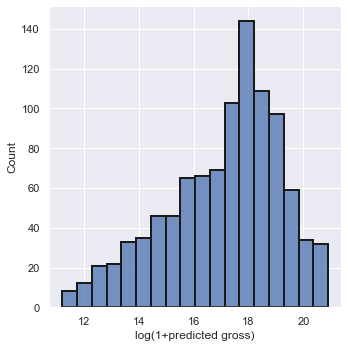

20.052883459730026
Predicted gross for the movie 'Sonic vs Batman 2': $188175098.0100626


In [120]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.2, train_size=0.8)
forest_model = RandomForestRegressor(max_leaf_nodes=500, random_state=0)
forest_model.fit(X_train, y_train)
predictions = forest_model.predict(X_valid)
print("MAE: " + str(mean_absolute_error(y_valid, predictions)))
print("Mean: " + str(y_valid.mean()))

forest_model.fit(X, y)
dream_predictions = forest_model.predict(dream_X)
print(y)
sns.displot(pd.Series(predictions, name = "log(1+predicted gross)"), edgecolor='k', linewidth=2)
plt.show()
for i in dream_movies.index:
    print("Predicted gross for the movie '{}': ${}".format(dream_movies["Title"][i], math.e**(dream_predictions[i]-1)))